# Assignment Lesson 5 - Hypothesis Simulation 

## Author - Kedar Ghayal



## Instructions
Use the <a href="https://archive.ics.uci.edu/ml/datasets/Automobile">automotive data set</a> to perform the following:

1. Identify a likely distribution for price and several other features.
2. Compute basic summary statistics by both classical, bootstrap, and Bayesian methods
3. Compute confidence intervals for these summary statistics by classical, bootstrap, and Bayesian methods
4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:
            Classical tests
            Tukey’s Honest Significant Differences (HSD)
            Bootstrap methods
            Bayesian model


### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [204]:
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"

In [205]:
# Load necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy.random as nr
import scipy.stats as ss
from itertools import *
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline

In [206]:
# Import data into data frame.
autoData = pd.read_csv(fileName)
# Convert to numeric , the numeric columns.
numericCol = ['normalized-losses','wheel-base','length','width','height','curb-weight','engine-size',
              'bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']
for column in numericCol:
    autoData[column] = pd.to_numeric(autoData[column], errors = 'coerce')
autoData.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


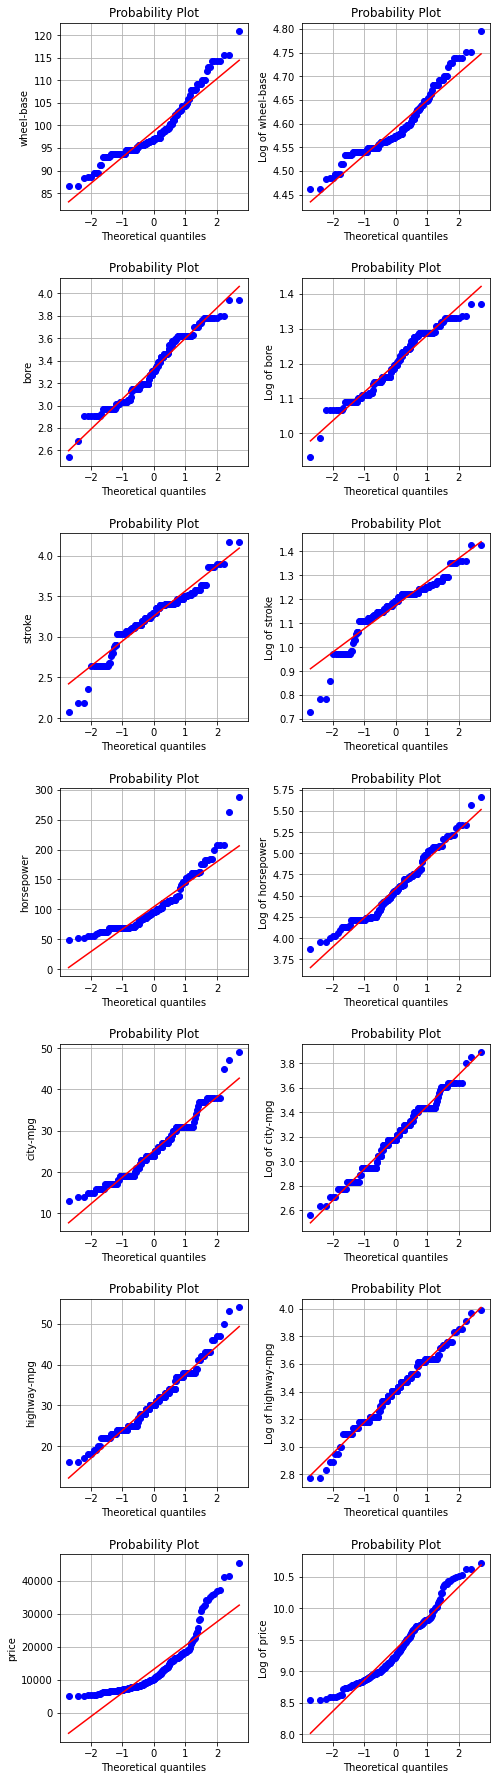

In [207]:
"""
In Below section , we will identify the likely distribution for the following continuous variables using pp plots.
'wheel-base' , 'bore','stroke', 'horsepower','city-mpg' , 'highway-mpg' , 'price'.
In the first section , we will compare the distribution of the variable with normal and log-normal distributions.
If they don't match we will evaluate a few alternative distributions.
"""
def prob_plot(vec1,vec2,ax1,ax2,ylabel, dist = 'norm',sparams = (0,1)):
    import scipy.stats as ss
    ax1.set_box_aspect(1)
    ax2.set_box_aspect(1)
    ss.probplot(vec1,dist = dist,sparams = sparams,plot = ax1) ## Plot the left subplot
    ax1.set(ylabel = ylabel)
    ax1.grid(True)
    ss.probplot(vec2,dist = dist,sparams = sparams,plot = ax2) ## Plot the right subplot
    ax2.set(ylabel = 'Log of '+ ylabel)
    ax2.grid(True)
    plt.tight_layout()
    
fig, axs = plt.subplots(7, 2,figsize = (7,25))
varList = ['wheel-base','bore','stroke','horsepower','city-mpg','highway-mpg','price'] # Var to be plotted.
for var ,row in zip(varList,range(0,8)):
    df1 = autoData[var].dropna()
    prob_plot(vec1 = df1,vec2 = np.log(df1),ax1 = axs[row,0],ax2 = axs[row,1],ylabel =var)
plt.show()

## Inference 1 
1 -For the features, wheel-base , bore, & stroke the regular as well as log distribution resembles normal though there are some outliers.

2- For the features: 'horsepower','city-mpg','highway-mpg','price' , log-values are much closer to normal & hence
    we will use log values in further analysis

In [208]:
#1 - Compute mean & Std Dev & confidence-intervals using existing data ( Classical)
df_classical = pd.DataFrame()
meanList = []
stdList = []
lowerCi = []
upperCi = []
log_list = ['horsepower','city-mpg','highway-mpg','price']
alpha = 0.95
for var in varList :
    if var in log_list:
        df1 = np.log(autoData[var].dropna())
    else:
        df1 = autoData[var].dropna()
    #Compute summary statistics
    
    mean = df1.mean()
    std = df1.std()
    half_width = ss.norm.ppf((1 + alpha)/2, loc=mean, scale=std) - mean
    ci_low = mean - half_width
    ci_high = mean + half_width
    
    # Calculate summary statistics from either regular data or data converted to log format.
    if var in log_list:
        meanList.append(np.exp(mean + std*std/2)) # getting mean from lognormal mean
        stdList.append(((np.exp(std*std) - 1)*np.exp(2*mean + std*std))**(1/2)) # getting var from lognormal var
        lowerCi.append(np.exp(ci_low))
        upperCi.append(np.exp(ci_high))
    else:
        meanList.append(mean)
        stdList.append(std)
        lowerCi.append(ci_low)
        upperCi.append(ci_high)

# Append results to summary df
df_classical['Variables'] = varList
df_classical['Classical Mean'] = np.round(meanList,3)
df_classical['Classical Std'] = np.round(stdList,3)
df_classical['Classical Lower CI'] = np.round(lowerCi,3)
df_classical['Classical Upper CI'] = np.round(upperCi,3)

df_classical.head(10)

,Variables,Classical Mean,Classical Std,Classical Lower CI,Classical Upper CI
0,wheel-base,98.757,6.022,86.954,110.559
1,bore,3.330,0.274,2.794,3.866
2,stroke,3.255,0.317,2.635,3.876
3,horsepower,103.975,37.136,49.650,193.106
4,city-mpg,25.225,6.591,14.749,40.387
5,highway-mpg,30.762,6.988,19.326,46.561
6,price,13046.079,6988.196,4297.204,30776.584


In [209]:
# Bootstrap ,Compute the means & confidence intervals for means based on 1000 replicas of the data
n_replicas = 1000
df_bootstrap = pd.DataFrame()
meanList = []
stdList = []
lowerCi = []
upperCi = []
log_list = ['horsepower','city-mpg','highway-mpg','price']
alpha = 0.95
varList = ['wheel-base','bore','stroke','horsepower','city-mpg','highway-mpg','price']
# Instead of using existing data we calculate the means of 1000 bootstrapped means.
for var in varList : # generate bootstrap samples
    autoData_means = pd.Series([autoData[var].dropna().sample(frac=1, replace=True).mean()
                                    for i in range(n_replicas)])
    if var in log_list:
        df1 = np.log(autoData_means)
    else:
        df1 = autoData_means
    #Compute summary statistics
    
    mean = df1.mean()
    std = df1.std()
    half_width = ss.norm.ppf((1 + alpha)/2, loc=mean, scale=std) - mean # calculate CI 
    ci_low = mean - half_width
    ci_high = mean + half_width
    
    # Calculate summary statistics from either regular data or data converted to log format.
    if var in log_list:
        meanList.append(np.exp(mean + std*std/2)) # getting mean from lognormal mean
        stdList.append(((np.exp(std*std) - 1)*np.exp(2*mean + std*std))**(1/2)) # getting var from lognormal var
        lowerCi.append(np.exp(ci_low))
        upperCi.append(np.exp(ci_high))
    else:
        meanList.append(mean)
        stdList.append(std)
        lowerCi.append(ci_low)
        upperCi.append(ci_high)
        
# Append results to summary df
df_bootstrap['Variables'] = varList
df_bootstrap['Bootstrap Mean'] = np.round(meanList,3)
df_bootstrap['Bootstrap Std for mean'] = np.round(stdList,3)
df_bootstrap['Bootstrap Lower CI for mean'] = np.round(lowerCi,3)
df_bootstrap['Bootstrap Upper CI for mean'] = np.round(upperCi,3)

df_bootstrap.head(10)

,Variables,Bootstrap Mean,Bootstrap Std for mean,Bootstrap Lower CI for mean,Bootstrap Upper CI for mean
0,wheel-base,98.749,0.431,97.904,99.594
1,bore,3.330,0.019,3.294,3.367
2,stroke,3.255,0.022,3.212,3.297
3,horsepower,104.285,2.840,98.829,109.961
4,city-mpg,25.237,0.456,24.354,26.143
5,highway-mpg,30.756,0.489,29.808,31.726
6,price,13212.853,570.557,12129.772,14365.856


# Bayesian Analysis

1) Since we don't know the mean & variance of the data beforehand,
We will assume a Normal -inverse gamma prior for each of the variable with the parameters 
NIG(mu =0,lambda = 1,alpha = 2,beta = 2)

2) It is a bi-variate distribution where variable x has a normal distribution and the variance has inverse-gamma distribution.

3) After observing the data, the marginal posterior distribution of x will be a normal distribution.

4) For 4 of the variables, the lognormal distribution will be used as above.

5) We will calculate the posterior hyperparameters based on the formula.



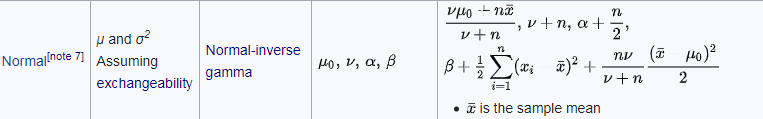

https://en.wikipedia.org/wiki/Conjugate_prior#cite_note-ppredNt-9

6) The Confidence intervals will be calculated from the marginal distribution of x & we are not interested in the distribution of sigma^2

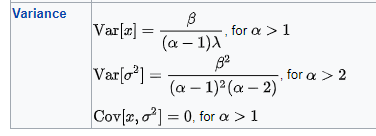

https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution

In [210]:
#Bayesian analysis

def calc_posterior ( mu, lamda, alpha , beta,data):
    xbar = data.mean()
    n = data.count()
    mu_post = (lamda*mu + n*xbar)/(lamda + n) # - Posterior mean
    lamda_post = lamda + n # posterior hyperparameters
    alpha_post = alpha + n/2
    beta_post = beta + (1/2)*np.sum((data -xbar)*(data-xbar)) + (n*lamda)/(lamda + n)*(1/2)*(xbar - mu)*(xbar - mu)
    
    stdx = (beta_post/lamda_post*(1/(alpha_post -1)))**(1/2) # std dev of x ( Marginal dist)
    lowerCi = mu_post - 2*stdx # Lower confidence interval from marginal dist of X
    upperci = mu_post + 2* stdx # Upper confidence interval from marginal dist of X
    return (mu_post,stdx,lowerCi,upperci)

df_bayesian = pd.DataFrame()
meanList = []
stdList = []
lowerCi = []
upperCi = []
for var in varList :
    if var in log_list:
        df1 = np.log(autoData[var].dropna())
    else:
        df1 = autoData[var].dropna()
    mean , std,ci_low,ci_high = calc_posterior(0,1,2,2,df1)
    # Calculate summary statistics from either regular data or data converted to log format.
    if var in log_list:
        meanList.append(np.exp(mean + std*std/2)) # getting mean from lognormal mean
        stdList.append(((np.exp(std*std) - 1)*np.exp(2*mean + std*std))**(1/2)) # getting var from lognormal var
        lowerCi.append(np.exp(ci_low))
        upperCi.append(np.exp(ci_high))
    else:
        meanList.append(mean)
        stdList.append(std)
        lowerCi.append(ci_low)
        upperCi.append(ci_high)
        
# Append results to summary df
df_bayesian['Variables'] = varList
df_bayesian['Bayesian Mean'] = np.round(meanList,3)
df_bayesian['Bayesian Std for mean'] = np.round(stdList,3)
df_bayesian['Bayesian Lower CI for mean'] = np.round(lowerCi,3)
df_bayesian['Bayesian Upper CI for mean'] = np.round(upperCi,3)

df_bayesian.head(10)

,Variables,Bayesian Mean,Bayesian Std for mean,Bayesian Lower CI for mean,Bayesian Upper CI for mean
0,wheel-base,98.277,0.633,97.010,99.544
1,bore,3.313,0.027,3.259,3.367
2,stroke,3.239,0.029,3.181,3.297
3,horsepower,95.797,3.286,89.396,102.537
4,city-mpg,24.038,0.612,22.838,25.285
5,highway-mpg,29.515,0.726,28.091,30.994
6,price,10998.912,646.534,9763.098,12348.488


## Inference 2

We have calculated the summary statistics by classical , bootstrap and Bayesian methods.

It appears that the results of Bayesian analysis are much closer to Bootstrap then the classical analysis.

In [211]:
# In this section we will test if the differences in price as conditioned by engine-type are significant.
# Step 1 - Apply classical ANOVA to the data
# Step 2 - Apply Tukey's HSD test to the data.
 

# Step 1 - Perform Anova for engine-type

df = autoData.loc[:,['engine-type','price']].dropna()

df1 = np.log(df.loc[df['engine-type']== 'dohc', 'price'])
df2 = np.log(df.loc[df['engine-type']== 'l', 'price'])
df3 = np.log(df.loc[df['engine-type']== 'ohc', 'price'])
df4 = np.log(df.loc[df['engine-type']== 'ohcf', 'price'])
df5 = np.log(df.loc[df['engine-type']== 'ohcv', 'price'])
df6 = np.log(df.loc[df['engine-type']== 'rotor', 'price'])
f_statistic, p_value = ss.f_oneway(df1, df2,df3,df4,df5,df6)
print('\nStep 1 - The results for one way anova for engine-type are as follows')
print('\nSince P value is low we infer that there is significant difference in at least one pair of prices based on engine type')
print('\nF statistic = ' + str(f_statistic))
print('\nP-value = ' + str(p_value))

# Step 2 - Apply Tukey's HSD test 

Tukey_HSD = pairwise_tukeyhsd(np.log(df['price']), df['engine-type'])
print('\nStep 2 - Tukey HSD test based on engine-type as conditioning var\n')
print(Tukey_HSD)


Step 1 - The results for one way anova for engine-type are as follows

Since P value is low we infer that there is significant difference in at least one pair of prices based on engine type

F statistic = 9.755399850009491

P-value = 2.470247592772414e-08

Step 2 - Tukey HSD test based on engine-type as conditioning var

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  dohc      l  -0.1815    0.9 -0.7161  0.3531  False
  dohc    ohc  -0.4867 0.0061   -0.88 -0.0933   True
  dohc   ohcf  -0.4163  0.175 -0.9234  0.0909  False
  dohc   ohcv   0.3087 0.5314 -0.2155  0.8329  False
  dohc  rotor  -0.2635    0.9 -1.0195  0.4924  False
     l    ohc  -0.3052 0.2275 -0.6985  0.0882  False
     l   ohcf  -0.2348 0.7393 -0.7419  0.2724  False
     l   ohcv   0.4902 0.0817  -0.034  1.0144  False
     l  rotor   -0.082    0.9  -0.838  0.6739  False
   ohc   ohcf   0.0704    0.9 -0.2847  0

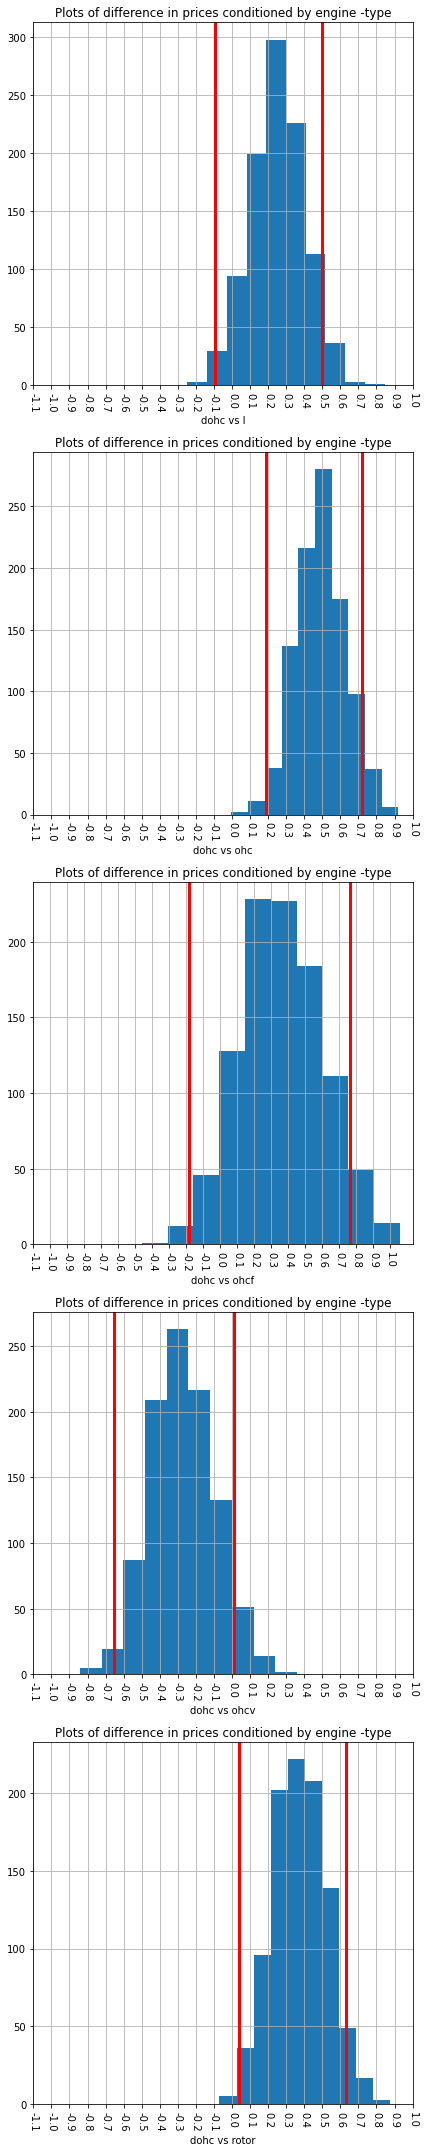

In [212]:
# In this section we will test if the differences in price as conditioned by engine-type are significant.
# Step 3 - Bootstrap the data & then graphically plot the means to identify overlap.

# Step 4 - Bootstrap means & perform graphical analysis of differences for only 5 of the differences.
"""
dohc vs l  
dohc vs ohc   
dohc vs ohcf  
dohc vs ohcv   
dohc vs rotor  
"""
n_replicas = 1000
engines = product(['dohc'],['l','ohc','ohcf','ohcv','rotor'])
df = autoData.loc[:,['engine-type','price']].dropna()
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(5,figsize = (6,30))
axeslist = (ax1, ax2,ax3,ax4,ax5)
xticks = [i/10 for i in range(-11,11,1)]
for x,y in zip(engines,axeslist):
    a,b = x
    diffs = []
    for i in range(n_replicas):
        sample = df.sample(frac=1.0, replace=True)
        sample1 = np.log(sample[sample['engine-type'] == a].price.mean())
        sample2 = np.log(sample[sample['engine-type'] == b].price.mean())
        diffs.append(sample1 - sample2)
    diffs1 = pd.Series(diffs)
    y.grid(True)
    y.hist(diffs1,align='right')
    y.axvline(np.percentile(diffs1.dropna(), 2.5), color='red', linewidth=3)
    y.axvline(np.percentile(diffs1.dropna(), 97.5), color='red', linewidth=3)
    y.set(title = 'Plots of difference in prices conditioned by engine -type' ,xlabel = '{0} vs {1}'.format(a,b),xticks = xticks)
    y.set_xticklabels(xticks, rotation=270)
    plt.tight_layout()
plt.show()

In [213]:
"""
Step 4 Bayesian analysis
In this step for each of the 5 scenarios ,
we assume a prior of Normal -inverse gamma with the parameters NIG(mu =0,lambda = 1,alpha = 2,beta = 2)
We then find the marginal posterior distribution of price( conditioned by the 5 engine types) & the 95% credible intervals.
Based on that we accept/reject the Null hypothesis that price distribution is same for all engine types
"""
df_bayesian2 = pd.DataFrame(columns = ['variable','mean','std_dev','lowerCi','upperCi'])

df = autoData.loc[:,['engine-type','price']].dropna()
engines = ['dohc','l','ohc','ohcf','ohcv','rotor']
for engine in engines:
    df1 = df[df['engine-type'] == engine]
    data1 = np.log(df1['price'])
    mean , std,ci_low,ci_high = calc_posterior(0,1,2,2,data1)
    list1 = pd.Series([engine,mean,std,ci_low,ci_high],index = df_bayesian2.columns).dropna()
    df_bayesian2 = df_bayesian2.append(list1,ignore_index=True)

df_bayesian2.head(10)    

,variable,mean,std_dev,lowerCi,upperCi
0,dohc,8.980030,0.715199,7.549631,10.410429
1,l,8.812495,0.701065,7.410365,10.214624
2,ohc,9.178407,0.074215,9.029978,9.326836
3,ohcf,8.730096,0.577611,7.574873,9.885318
4,ohcv,9.320141,0.689851,7.940439,10.699843
5,rotor,7.571867,1.588932,4.394003,10.749730


# Final inference

We have seen the results of the Tukey HSD test , Bootstrap and Bayesian methods above for price , stratified by engine -type.

In Bootstrap diff plot, we can see the diff as significant if 0 is not included in 95% conf interval.

In Bayesian analysis, we see that almost all CI are overlapping and hence results are not significant.

scenario|Tukey|Bootstrap |Bayesian
---|---|---|---
dohc vs l |Not significant|Not significant|Not significant 
dohc vs ohc |Significant|Significant|Not significant
dohc vs ohcf|Not significant|Not significant|Not significant
dohc vs ohcv|Not significant|Not significant|Not significant
dohc vs rotor|Not significant|Significant|Not significant